### Import required packages

In [205]:
import os
import re
import json
# import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import floor
from collections import Counter
# from factory_func import plot_confusion_matrix
from sklearn.utils import shuffle
from sklearn.preprocessing import Normalizer
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import confusion_matrix, f1_score, roc_curve

In [230]:
from keras.layers import Input, Dense, Embedding, Conv1D, Conv2D, Lambda, LSTM, ConvLSTM2D, TimeDistributed, Masking, Bidirectional
from keras.layers import Reshape, Flatten, Dropout, Concatenate, Activation, MaxPooling1D, GlobalAveragePooling1D, MaxPooling2D, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing import sequence
from keras.models import Model, load_model, Sequential
from keras.optimizers import Adam
from keras.regularizers import l2, l1
from keras.utils import to_categorical
from keras import optimizers
import keras.backend as K

In [145]:
# import gzip
# from gensim.models import Word2Vec

### 1. ETL & Cleansing  
### 2. Rebalancing (Undersampling)  
### 3. Feature Extraction  
### 4. Model Selection & Evaluation  

## Accuracy Records  
SVM: 45.5172%  
Dense NN: 45.1724%  
CNN: 47.2414%  
LSTM: tbc  
  
*(there might be a ceiling for how much you can improve the accuracy)*

## Data Import

In [146]:
dev_raw = pd.read_csv(os.path.join(os.getcwd(), 'data','dev_sent_emo.csv'))
train_raw = pd.read_csv(os.path.join(os.getcwd(), 'data','train_sent_emo.csv'))
test_raw = pd.read_csv(os.path.join(os.getcwd(), 'data','test_sent_emo.csv'))

In [147]:
dev_raw.head()

,Sr No.,Utterance,Speaker,Emotion,Sentiment,Dialogue_ID,Utterance_ID,Season,Episode,StartTime,EndTime
0,1,"Oh my God, hes lost it. Hes totally lost it.",Phoebe,sadness,negative,0,0,4,7,"00:20:57,256","00:21:00,049"
1,2,What?,Monica,surprise,negative,0,1,4,7,"00:21:01,927","00:21:03,261"
2,3,"Or! Or, we could go to the bank, close our acc...",Ross,neutral,neutral,1,0,4,4,"00:12:24,660","00:12:30,915"
3,4,Youre a genius!,Chandler,joy,positive,1,1,4,4,"00:12:32,334","00:12:33,960"
4,5,"Aww, man, now we wont be bank buddies!",Joey,sadness,negative,1,2,4,4,"00:12:34,211","00:12:37,505"


## Labels Distribution

Text(0.5, 1.0, 'testing set')

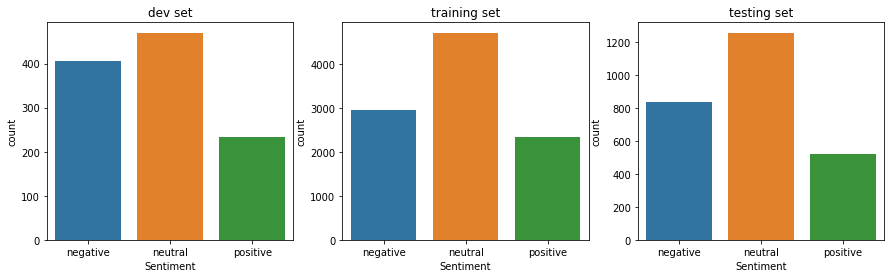

In [148]:
f, axes = plt.subplots(1, 3, figsize=(15,4))
sns.countplot(x='Sentiment', data=dev_raw, ax=axes[0], order=['negative','neutral','positive']).set_title('dev set')
sns.countplot(x='Sentiment', data=train_raw, ax=axes[1], order=['negative','neutral','positive']).set_title('training set')
sns.countplot(x='Sentiment', data=test_raw, ax=axes[2], order=['negative','neutral','positive']).set_title('testing set')

In [149]:
print(Counter(dev_raw.Sentiment))
print(Counter(train_raw.Sentiment))
print(Counter(test_raw.Sentiment))

Counter({'neutral': 470, 'negative': 406, 'positive': 233})
Counter({'neutral': 4710, 'negative': 2945, 'positive': 2334})
Counter({'neutral': 1256, 'negative': 833, 'positive': 521})


In [150]:
dev_raw.Utterance = dev_raw.Utterance.apply(lambda x: re.sub('\\x92', "'", x))
train_raw.Utterance = train_raw.Utterance.apply(lambda x: re.sub('\\x92', "'", x))
test_raw.Utterance = test_raw.Utterance.apply(lambda x: re.sub('\\x92', "'", x))

Text(0.5, 1.0, 'train+test set')

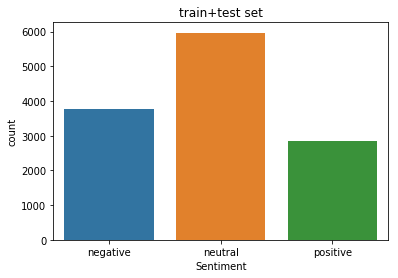

In [151]:
train_raw['source'] = 'train'
test_raw['source'] = 'test'
data_raw = pd.concat([train_raw, test_raw])
data_raw.shape
sns.countplot(x='Sentiment', data=data_raw, order=['negative','neutral','positive']).set_title('train+test set')

## Resampling  
To deal with imbalanced datasets.

In [152]:
count_neutral, count_negative, count_positive = data_raw.Sentiment.value_counts()
print(f'There are {count_negative} negative, {count_neutral} neutral and {count_positive} positive utternaces.')

There are 3778 negative, 5966 neutral and 2855 positive utternaces.


In [153]:
tmp_df_negative = data_raw[data_raw.Sentiment == 'negative']
tmp_df_neutral = data_raw[data_raw.Sentiment == 'neutral']
tmp_df_positive = data_raw[data_raw.Sentiment == 'positive']

tmp_df_negative_undersampled = tmp_df_negative.sample(floor(count_positive*1.1)).reset_index(drop=True)
tmp_df_neutral_undersampled = tmp_df_neutral.sample(floor(count_positive*0.95)).reset_index(drop=True)

In [154]:
data_balanced = pd.concat([tmp_df_negative_undersampled, tmp_df_neutral_undersampled, tmp_df_positive], axis=0)
data_balanced = shuffle(data_balanced)
data_balanced.head()

,Sr No.,Utterance,Speaker,Emotion,Sentiment,Dialogue_ID,Utterance_ID,Season,Episode,StartTime,EndTime,source
2714,2868,What? No-no it's her birthday!,Joey,surprise,positive,288,2,6,13,"0:15:42,316","0:15:44,418",train
135,1314,No!,Phoebe,surprise,negative,132,19,8,23,"0:15:04,183","0:15:05,685",test
648,668,Toby!,Bob,joy,positive,62,3,8,5,"00:07:29,532","00:07:32,033",train
1724,7550,"Y'know, I don't know if you've ever looked up ...",Chandler,neutral,neutral,757,2,5,3,"00:18:12,132","00:18:36,405",train
386,307,"Ok, go quick!",Chandler,fear,negative,29,10,9,19,"00:17:29,883","00:17:32,427",test


There are 3140 negative, 2712 neutral and 2855 positive utternaces.


Text(0.5, 1.0, 'rebalanced set')

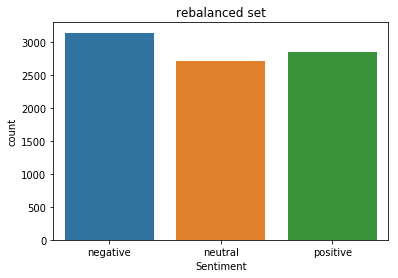

In [155]:
new_c_negative, new_c_positive, new_c_neutral = data_balanced.Sentiment.value_counts()
print(f'There are {new_c_negative} negative, {new_c_neutral} neutral and {new_c_positive} positive utternaces.')
sns.countplot(x='Sentiment', data=data_balanced, order=['negative','neutral','positive']).set_title('rebalanced set')

## Preprocessing

In [188]:
print('The longest utterance contains {} words.'.format(max([len(x.split(' ')) for x in data_balanced.Utterance])))

The longest utterance contains 45 words.


In [209]:
# For sentiment analysis
num_polarities = 3
max_sequence_len = 50

vocabulary_size = 6000
tokenizer = Tokenizer(num_words= vocabulary_size, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{}~', lower=True)
tokenizer.fit_on_texts(data_balanced.Utterance.values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 5392 unique tokens.


In [210]:
X = tokenizer.texts_to_sequences(data_balanced.Utterance.values)
X = pad_sequences(X, maxlen=max_sequence_len)
print('Shape of data tensor:', X.shape)

# X = tokenizer.texts_to_matrix(data_balanced.Utterance, mode='tfidf')
# print('Shape of data tensor:', X.shape)
# X[0]

Shape of data tensor: (8707, 50)


In [211]:
# Prep target labels for sentiment analysis
y = data_balanced.Sentiment.values
sen_targets, sen_uniques = pd.factorize(y, sort=True)
y = to_categorical(sen_targets, num_polarities)

In [212]:
sen_label_map = dict(zip(list(sen_uniques), range(num_polarities)))
sen_label_map

{'negative': 0, 'neutral': 1, 'positive': 2}

In [213]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)

## Factory functions

In [226]:
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('epoch')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('epoch')
    plt.legend()

## Models

### Tfidf + SVM

In [42]:

tfidf = TfidfVectorizer(lowercase=True, stop_words='english', ngram_range=(1,3))
tfidf.fit(x_train)
x_dev_tf = tfidf.transform(x_dev)
x_train_tf = tfidf.transform(x_train)
x_test_tf = tfidf.transform(x_test)

In [24]:
# svd = TruncatedSVD(n_components=300)
# x_dev_tr = svd.fit_transform(x_dev_tf)
# x_train_tr = svd.fit_transform(x_train_tf)
# x_test_tr = svd.fit_transform(x_test_tf)

In [10]:
svm = SVC(C=10, kernel='linear', probability=True)
# param_grid = { 
#     'C': [1,10,100], 'kernel': ['linear', 'rbf']
# }
# clf = GridSearchCV(estimator=svm, param_grid=param_grid, cv=5)
# clf.fit(x_train_tr, y_train)

In [10]:
# clf.best_estimator_

**Best model by GridSearchCV**  
SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,  
decision_function_shape='ovr', degree=3, gamma='auto_deprecated',  
kernel='linear', max_iter=-1, probability=True, random_state=None,  
shrinking=True, tol=0.001, verbose=False)

In [227]:
svm.fit(X=x_train_tf, y=y_train)
y_pred_svm = svm.predict(x_test_tf)

In [16]:
f1_score(y_pred=y_pred_svm, y_true=y_test, average="weighted")

0.42923347861223476

In [228]:
svm_accuracy = 100*np.sum(y_pred_svm==y_test)/len(y_pred_svm)
print('Test accuracy: %.4f%%' % svm_accuracy)

Test accuracy: 45.5172%


### Keras TF-IDF tokenizer + Neural nets

Neural network won't accept sentences with different dimension(i.e. number of words) as input. By padding the inputs, we decide the maximum length of words in a sentence, then zero pads the rest, if the input length is shorter than the designated length. In the case where it exceeds the maximum length, then it will also truncate either from the beginning or from the end.  
*Ref_1* https://keras.io/preprocessing/sequence/  
*Ref_2* https://towardsdatascience.com/another-twitter-sentiment-analysis-with-python-part-11-cnn-word2vec-41f5e28eda74

https://medium.com/@sabber/classifying-yelp-review-comments-using-lstm-and-word-embeddings-part-1-eb2275e4066b
#### Dense - Fully Connected Layers

In [215]:
dense_checkpts = ModelCheckpoint(filepath=os.path.join(os.getcwd(),'saved_models','text','dense.weights.best.hdf5'), 
                               verbose=1, save_best_only=True)

In [229]:
dense = Sequential()
dense.add(Dense(32, activation='relu', input_dim=max_sequence_len))
dense.add(Dropout(0.2))
dense.add(Dense(64, activation='relu'))
dense.add(BatchNormalization())
dense.add(Dense(128, activation='relu'))
dense.add(BatchNormalization())
dense.add(Dense(num_polarities, activation='softmax'))
dense.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
dense.summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_17 (Dense)             (None, 32)                1632      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_18 (Dense)             (None, 64)                2112      
_________________________________________________________________
batch_normalization_3 (Batch (None, 64)                256       
_________________________________________________________________
dense_19 (Dense)             (None, 128)               8320      
_________________________________________________________________
batch_normalization_4 (Batch (None, 128)               512       
___________________________

In [233]:
dense_history=dense.fit(x_train, y_train, validation_split=0.4, epochs=100, callbacks=[dense_checkpts], verbose=1)

Train on 3499 samples, validate on 2334 samples
Epoch 1/100
3499/3499 [==============================] - 1s 275us/step - loss: 1.2615 - acc: 0.3370 - val_loss: 1.1334 - val_acc: 0.3650

Epoch 00001: val_loss improved from 1.55473 to 1.13343, saving model to /Users/cheuky/Documents/Code_Blue/ml_nanodegree/capstone/saved_models/text/dense.weights.best.hdf5
Epoch 2/100
3499/3499 [==============================] - 0s 81us/step - loss: 1.1664 - acc: 0.3518 - val_loss: 1.1317 - val_acc: 0.3689

Epoch 00002: val_loss improved from 1.13343 to 1.13171, saving model to /Users/cheuky/Documents/Code_Blue/ml_nanodegree/capstone/saved_models/text/dense.weights.best.hdf5
Epoch 3/100
3499/3499 [==============================] - 0s 79us/step - loss: 1.1407 - acc: 0.3692 - val_loss: 1.1200 - val_acc: 0.3505

Epoch 00003: val_loss improved from 1.13171 to 1.12002, saving model to /Users/cheuky/Documents/Code_Blue/ml_nanodegree/capstone/saved_models/text/dense.weights.best.hdf5
Epoch 4/100
3499/3499 [====

3499/3499 [==============================] - 0s 97us/step - loss: 1.0754 - acc: 0.3984 - val_loss: 1.1120 - val_acc: 0.3749

Epoch 00038: val_loss did not improve from 1.10517
Epoch 39/100
3499/3499 [==============================] - 0s 104us/step - loss: 1.0776 - acc: 0.3975 - val_loss: 1.1134 - val_acc: 0.3762

Epoch 00039: val_loss did not improve from 1.10517
Epoch 40/100
3499/3499 [==============================] - 0s 85us/step - loss: 1.0761 - acc: 0.4081 - val_loss: 1.1200 - val_acc: 0.3535

Epoch 00040: val_loss did not improve from 1.10517
Epoch 41/100
3499/3499 [==============================] - 0s 82us/step - loss: 1.0725 - acc: 0.4050 - val_loss: 1.1164 - val_acc: 0.3655

Epoch 00041: val_loss did not improve from 1.10517
Epoch 42/100
3499/3499 [==============================] - 0s 83us/step - loss: 1.0728 - acc: 0.3993 - val_loss: 1.1203 - val_acc: 0.3775

Epoch 00042: val_loss did not improve from 1.10517
Epoch 43/100
3499/3499 [==============================] - 0s 76us/s

3499/3499 [==============================] - 0s 94us/step - loss: 1.0495 - acc: 0.4298 - val_loss: 1.1358 - val_acc: 0.3646

Epoch 00081: val_loss did not improve from 1.10517
Epoch 82/100
3499/3499 [==============================] - 0s 92us/step - loss: 1.0451 - acc: 0.4401 - val_loss: 1.1346 - val_acc: 0.3693

Epoch 00082: val_loss did not improve from 1.10517
Epoch 83/100
3499/3499 [==============================] - 0s 95us/step - loss: 1.0436 - acc: 0.4244 - val_loss: 1.1433 - val_acc: 0.3578

Epoch 00083: val_loss did not improve from 1.10517
Epoch 84/100
3499/3499 [==============================] - 0s 98us/step - loss: 1.0502 - acc: 0.4296 - val_loss: 1.1384 - val_acc: 0.3590

Epoch 00084: val_loss did not improve from 1.10517
Epoch 85/100
3499/3499 [==============================] - 0s 85us/step - loss: 1.0468 - acc: 0.4324 - val_loss: 1.1512 - val_acc: 0.3363

Epoch 00085: val_loss did not improve from 1.10517
Epoch 86/100
3499/3499 [==============================] - 0s 82us/st

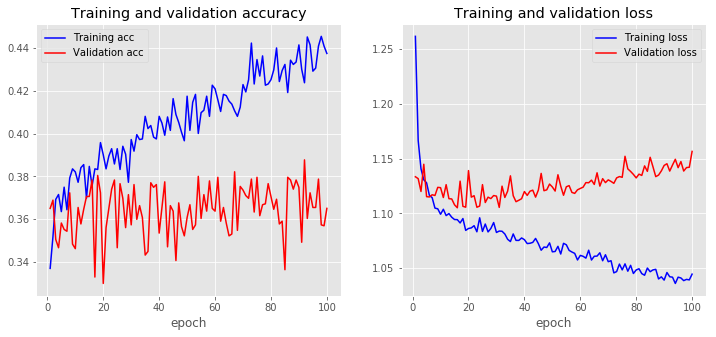

In [234]:
plot_history(dense_history)

In [235]:
y_pred_dense = dense.predict_classes(x_test)
Counter(y_pred_dense)

Counter({0: 911, 1: 558, 2: 1405})

In [239]:
dense_accuracy = dense.evaluate(x_test, y_test, batch_size=128)[1] * 100
print('Test accuracy: %.4f%%' % dense_accuracy)

2874/2874 [==============================] - 0s 8us/step
Test accuracy: 36.4649%


__About batch_size__  
Advantages of using a batch size < number of all samples:

- It requires less memory. Since you train the network using fewer samples, the overall training procedure requires less memory. That's especially important if you are not able to fit the whole dataset in your machine's memory.

- Typically networks train faster with mini-batches. That's because we update the weights after each propagation. In our example we've propagated 11 batches (10 of them had 100 samples and 1 had 50 samples) and after each of them we've updated our network's parameters. If we used all samples during propagation we would make only 1 update for the network's parameter.

Disadvantages of using a batch size < number of all samples:

- The smaller the batch the less accurate the estimate of the gradient will be.

### CNN - Convolutional Layers
Conv1D is generally good for text, whereas Conv2D is good for audio and images where spatial matter

In [14]:
num_classes = 7
n_length = x_train.shape[0]
n_features = x_train.shape[1]

x_train_reshaped = x_train.reshape(n_length, n_features, 1)
x_test_reshaped = x_test.reshape(x_test.shape[0], n_features, 1)

In [79]:
cnn_checkpts = ModelCheckpoint(filepath=os.path.join(os.getcwd(), 'cnn.weights.best.hdf5'), 
                               verbose=1, save_best_only=True)

In [80]:
def build_CNN(num_classes):
    cnn = Sequential()
    cnn.add(Conv1D(filters=16, kernel_size=2, padding='same', activation='relu', input_shape=(n_features, 1)))
    cnn.add(MaxPooling1D(pool_size=2))
    cnn.add(Conv1D(filters=32, kernel_size=2, padding='same', activation='relu'))
    cnn.add(MaxPooling1D(pool_size=2))
    cnn.add(Conv1D(filters=64, kernel_size=2, padding='same', activation='relu'))
    cnn.add(MaxPooling1D(pool_size=2))
    # cnn.add(GlobalAveragePooling1D())
    cnn.add(Flatten())
    cnn.add(Dense(128, activation='relu'))
    cnn.add(Dense(num_classes, activation='softmax'))
    cnn.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])
    print(cnn.summary())
    return cnn

In [81]:
cnn = build_CNN(num_classes)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, 20000, 16)         48        
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 10000, 16)         0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 10000, 32)         1056      
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 5000, 32)          0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 5000, 64)          4160      
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 2500, 64)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 160000)            0         
__________

In [82]:
cnn.fit(x_train_reshaped, y_train, validation_split=0.4, epochs=5, callbacks=[cnn_checkpts], verbose=1)

Train on 5993 samples, validate on 3996 samples
Epoch 1/5
5993/5993 [==============================] - 46s 8ms/step - loss: 1.5400 - acc: 0.4724 - val_loss: 1.4826 - val_acc: 0.4855

Epoch 00001: val_loss improved from inf to 1.48262, saving model to /home/ubuntu/cnn.weights.best.hdf5
Epoch 2/5
5993/5993 [==============================] - 17s 3ms/step - loss: 1.2248 - acc: 0.5496 - val_loss: 1.5161 - val_acc: 0.4852

Epoch 00002: val_loss did not improve from 1.48262
Epoch 3/5
5993/5993 [==============================] - 17s 3ms/step - loss: 0.8583 - acc: 0.6848 - val_loss: 1.7594 - val_acc: 0.4622

Epoch 00003: val_loss did not improve from 1.48262
Epoch 4/5
5993/5993 [==============================] - 17s 3ms/step - loss: 0.5880 - acc: 0.7873 - val_loss: 2.1419 - val_acc: 0.4417

Epoch 00004: val_loss did not improve from 1.48262
Epoch 5/5
5993/5993 [==============================] - 17s 3ms/step - loss: 0.4343 - acc: 0.8453 - val_loss: 2.5547 - val_acc: 0.4362

Epoch 00005: val_loss

In [83]:
y_pred_cnn = cnn.predict_classes(x_test_reshaped)
# y_pred_cnn = [np.argmax(x) for x in cnn.predict(x_test_reshaped)]
Counter(y_pred_cnn)

Counter({4: 1519, 3: 377, 5: 129, 1: 49, 6: 270, 0: 229, 2: 37})

In [84]:
# cnn_accuracy = 100*np.sum(y_pred_cnn==y_true)/len(y_pred_cnn)
# print('Test accuracy: %.4f%%' % cnn_accuracy)
cnn_accuracy = cnn.evaluate(x_test_reshaped, y_true, batch_size=128)[1] * 100
print('Test accuracy: %.4f%%' % cnn_accuracy)

2610/2610 [==============================] - 2s 673us/step
Test accuracy: 43.6782%


In [67]:
# cnn_score = cnn.evaluate(x_test_reshaped, y_pred_cnn, verbose=1)
# print("%s: %.2f%%" % (cnn.metrics_names[1], cnn_score[1]*100))

Serialise the model architecture to JSON

In [18]:
with open(os.path.join(os.getcwd(), "saved_models", "text", "emotion", "cnn.model.json", "w") as json_file:
    json_file.write(cnn.to_json())

In [ ]:
# load json and create model
json_file = open('./saved_models/text/emotion/cnn.json', 'r')
loaded_cnn_json = json_file.read()
json_file.close()
loaded_cnn = model_from_json(loaded_cnn_json)
# load weights into new model
loaded_cnn.load_weights("cnn.weights.best.hdf5")
print("Loaded model from disk")

In [8]:
# ENGLISH_STOP_WORDS

### WordEnbedding + LSTM  
- checkpoint: try a pre-trained embedding layer e.g. GloVe Embedding, Word2Vec  
  
Building the embedding from scratch instead of using pre-trained (*this can be a slower approach, but tailors the model to a specific training dataset*)  

Ref_1: https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/

In [20]:
lstm_checkpts = ModelCheckpoint(filepath=os.path.join(os.getcwd() + '/saved_models/text/emotion/lstm.weights.best.hdf5'), 
                               verbose=1, save_best_only=True)

In [69]:
# vocabulary_size = 20000
embedding_size=128
lstm_output_size=64  #70
num_classes=7

lstm = Sequential()
lstm.add(Embedding(input_dim=vocabulary_size, output_dim=embedding_size, input_length=20000))
lstm.add(LSTM(units=lstm_output_size, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
lstm.add(Flatten())
lstm.add(Dense(num_classes, activation='sigmoid'))
          
lstm.compile(loss='categorical_crossentropy',
            optimizer='adam',
            metrics=['accuracy'])
lstm.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, 20000, 128)        2560000   
_________________________________________________________________
lstm_13 (LSTM)               (None, 20000, 64)         49408     
_________________________________________________________________
flatten_9 (Flatten)          (None, 1280000)           0         
_________________________________________________________________
dense_8 (Dense)              (None, 7)                 8960007   
Total params: 11,569,415
Trainable params: 11,569,415
Non-trainable params: 0
_________________________________________________________________


In [70]:
lstm.fit(x_train, y_train, validation_split=0.4, epochs=1, callbacks=[lstm_checkpts], verbose=1)

Train on 5993 samples, validate on 3996 samples
Epoch 1/3
5993/5993 [==============================] - 1072s 179ms/step - loss: 1.5608 - acc: 0.4726 - val_loss: 1.5449 - val_acc: 0.4670

Epoch 00001: val_loss improved from inf to 1.54495, saving model to C:\Users\syip\Desktop\DaSci\Nanodegree\ml_nanodegree\capstone/saved_models/lstm.weights.best.hdf5
Epoch 2/3
5993/5993 [==============================] - 1074s 179ms/step - loss: 1.5429 - acc: 0.4746 - val_loss: 1.5357 - val_acc: 0.4670

Epoch 00002: val_loss improved from 1.54495 to 1.53567, saving model to C:\Users\syip\Desktop\DaSci\Nanodegree\ml_nanodegree\capstone/saved_models/lstm.weights.best.hdf5
Epoch 3/3
5993/5993 [==============================] - 1067s 178ms/step - loss: 1.5419 - acc: 0.4746 - val_loss: 1.5396 - val_acc: 0.4670

Epoch 00003: val_loss did not improve from 1.53567


In [72]:
y_pred_lstm = lstm.predict_classes(x_test)
Counter(y_pred_lstm)

Counter({4: 2610})

In [ ]:
lstm_accuracy = 100*np.sum(y_pred_lstm==y_true)/len(y_pred_lstm)
print('Test accuracy: %.4f%%' % lstm_accuracy)

In [37]:
loaded_lstm = load_model('./saved_models/text/emotion/lstm.weights.best.hdf5')

In [38]:
loaded_lstm.predict_classes(x_test[:6])

array([4, 4, 4, 4, 4, 4], dtype=int64)

### WordEmbedding + ConvLSTM

In [66]:
max_features=20000
embedding_size=128
lstm_output_size=32  #70
num_classes=7

conv_lstm = Sequential()
conv_lstm.add(Embedding(input_dim=max_features, output_dim=embedding_size, input_length=20000))
conv_lstm.add(Dropout(0.25))
conv_lstm.add(Conv1D(filters=64,
                 kernel_size=5,
                 padding='valid',
                 activation='relu',
                 strides=1))
conv_lstm.add(MaxPooling1D(pool_size=4))
conv_lstm.add(LSTM(units=lstm_output_size, return_sequences=True), activity_regularizer=l1(0.001))
conv_lstm.add(Flatten())
conv_lstm.add(Dense(num_classes, activation='softmax'))

conv_lstm.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
conv_lstm.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 20000, 128)        2560000   
_________________________________________________________________
dropout_8 (Dropout)          (None, 20000, 128)        0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 19996, 64)         41024     
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 4999, 64)          0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 4999, 32)          12416     
_________________________________________________________________
flatten_6 (Flatten)          (None, 159968)            0         
_________________________________________________________________
dense_7 (Dense)              (None, 7)                 1119783   
Total para

In [ ]:
conv_lstm_checkpts = ModelCheckpoint(filepath=os.path.join(os.getcwd() + '/saved_models/text/emotion/conv_lstm.weights.best.hdf5'), 
                               verbose=1, save_best_only=True)

In [ ]:
conv_lstm.fit(x_train, y_train, validation_split=0.4, callback=[conv_lstm_checkpts], epochs=1, verbose=1)

In [22]:
y_pred_conv_lstm = conv_lstm.predict_classes(x_test)
Counter(y_pred_conv_lstm)

Counter({4: 2610})

In [25]:
conv_lstm_accuracy = 100*np.sum(y_pred_conv_lstm==y_true)/len(y_true)
print('Test accuracy: %.4f%%' % conv_lstm_accuracy)

Test accuracy: 0.0000%


C:\Users\syip\anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  """Entry point for launching an IPython kernel.


### Word2Vec  
Do transfer learning with pre-trained word embedding layers, such as Word2Vec & GloVe

In [ ]:
x_dev_tokens = [sentence.split() for sentence in x_dev]
x_train_tokens = [sentence.split() for sentence in x_train]

model = Word2Vec(
    x_train_tokens,
    size=150,
    window=10,
    min_count=2,
    workers=10)

The first parameter passed to gensim.models.Word2Vec is an iterable of sentences. Sentences themselves are a list of words

In [ ]:
model.train(x_train_tokens, total_examples=len(x_train), epochs=10)

w = ['good']
# w = filter(lambda x: x in model.vocab, x_train.tokens)
model.wv.most_similar(positive=w,
#                       topn=6
                     )

### GloVe

Extract word embeddings from the Glove

In [33]:
embeddings_index = dict()
f = open('glove.6B.100d.txt', encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

Create a weight matrix

In [34]:
# vocabulary_size=9000

embedding_matrix = np.zeros((vocabulary_size, 100))
for word, index in tokenizer.word_index.items():
    if index > vocabulary_size - 1:
        break
    else:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector

Create ConvLSTM model with GloVe

In [32]:
def build_ConvLSTM(num_classes, vocabulary_size=None, dense_activation=None, optimizer=None, use_glove=None):
    dense_activation = dense_activation or 'softmax'
    optimizer = optimizer or 'adam'
    use_glove = use_glove or True
    embedding_size=100
    lstm_output_size=128
    vocabulary_size= vocabulary_size or 20000
    
    model = Sequential()
    if use_glove:
        model.add(Embedding(input_dim=vocabulary_size, output_dim=embedding_size, input_length=vocabulary_size,
                            weights=[embedding_matrix], trainable=False))
    else:
        model.add(Embedding(input_dim=vocabulary_size, output_dim=embedding_size, input_length=vocabulary_size))
    model.add(Dropout(0.2))
    model.add(Conv1D(filters=64,
                     kernel_size=5,
                     padding='valid',
                     activation='relu',
                     kernel_regularizer=l2(0.01),
                     strides=1))
    model.add(MaxPooling1D(pool_size=4))
    model.add(LSTM(units=lstm_output_size, return_sequences=True))
    model.add(BatchNormalization())
    model.add(TimeDistributed(Dense(32)))
#     model.add(Flatten())
    model.add(GlobalAveragePooling1D())
    model.add(Dense(16, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(Dense(num_classes, activation=dense_activation))
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    print(model.summary())
    return model

In [35]:
glove_checkpts = ModelCheckpoint(filepath=os.path.join(os.getcwd() + '/saved_models/text/emotion/glove.weights.best.hdf5'), 
                               verbose=1, save_best_only=True)

glove.fit(x_train, y_train, validation_split=0.4, epochs=1, callbacks=[glove_checkpts], verbose=1)

In [18]:
y_pred_glove = glove.predict_classes(x_test)
Counter(y_pred_glove)

Counter({4: 2610})

In [20]:
Counter(targets)

Counter({4: 4710, 6: 1205, 2: 268, 5: 683, 3: 1743, 1: 271, 0: 1109})

## Sentiment Analysis  
__Predicting 3 classes: Positive, Negative & Neutral__  
  
**Models ready at disposal:**  
- svm  
- dense  
- cnn  
- lstm  
- conv_lstm  

**Accuracy records**  
- cnn: 48.5824%  
- lstm with glove: 48.3908%

In [89]:
z_train

array([[0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       ...,
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.]], dtype=float32)

In [36]:
num_polarities = 3

# sen_targets, sen_uniques = pd.factorize(z_train, sort=True)
# z_train = to_categorical(sen_targets, num_polarities)

sen_label_map = dict(zip(list(sen_uniques), range(num_polarities)))
sen_label_map

{'negative': 0, 'neutral': 1, 'positive': 2}

In [37]:
Counter(sen_targets)

Counter({1: 4710, 2: 2334, 0: 2945})

### GloVe + LSTM  
Note: To solve the problem of LSTM always predicting the same class even when trained with balanced data, the 'return_sequences' param in the LSTM layer needs to be set to True and add a Flatten layer. In addition, 'return_sequences=True' must be set when stacking LSTM layers so that the second LSTM layer has a three-dimensional sequence inpu

In [40]:
sen_glove = build_ConvLSTM(num_classes=num_polarities, vocabulary_size=vocabulary_size, dense_activation='softmax',
                           optimizer=optimizers.adam(lr=0.001), use_glove=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 12000, 100)        1200000   
_________________________________________________________________
dropout_2 (Dropout)          (None, 12000, 100)        0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 11996, 64)         32064     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 2999, 64)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 2999, 128)         98816     
_________________________________________________________________
batch_normalization_1 (Batch (None, 2999, 128)         512       
_________________________________________________________________
time_distributed_1 (TimeDist (None, 2999, 32)          4128      
__________

Note: to use 'callback', one must provide 'validation_split' or 'validation_data'

In [41]:
glove_checkpts = ModelCheckpoint(filepath=os.path.join(os.getcwd(), 'glove.weights.best.hdf5'), 
                               verbose=1, save_best_only=True)
# (Optional) load model
# sen_glove.load_weights(os.path.join(os.getcwd(), 'glove.weights.best.hdf5'))

In [42]:
glove_history = sen_glove.fit(x_train, z_train, validation_split=0.33, epochs=10, 
                              class_weight={0: 1.5, 1: 1., 2: 1.8}, callbacks=[glove_checkpts], verbose=1)

Instructions for updating:
Use tf.cast instead.
Train on 6692 samples, validate on 3297 samples
Epoch 1/10
6692/6692 [==============================] - 1117s 167ms/step - loss: 1.6516 - acc: 0.4274 - val_loss: 1.5440 - val_acc: 0.3649

Epoch 00001: val_loss improved from inf to 1.54401, saving model to /home/ubuntu/glove.weights.best.hdf5
Epoch 2/10
6692/6692 [==============================] - 1093s 163ms/step - loss: 1.4754 - acc: 0.4399 - val_loss: 2.0935 - val_acc: 0.4583

Epoch 00002: val_loss did not improve from 1.54401
Epoch 3/10
6692/6692 [==============================] - 1092s 163ms/step - loss: 1.4607 - acc: 0.4256 - val_loss: 1.8657 - val_acc: 0.4583

Epoch 00003: val_loss did not improve from 1.54401
Epoch 4/10
6692/6692 [==============================] - 1085s 162ms/step - loss: 1.4581 - acc: 0.4162 - val_loss: 1.5282 - val_acc: 0.2323

Epoch 00004: val_loss improved from 1.54401 to 1.52817, saving model to /home/ubuntu/glove.weights.best.hdf5
Epoch 5/10
5888/6692 [======

KeyboardInterrupt: 

In [43]:
z_pred_glove = sen_glove.predict_classes(x_test)
Counter(z_pred_glove)

Counter({1: 2610})

In [44]:
glove_accuracy = 100*np.sum(z_pred_glove==z_transf)/len(z_transf)
print('Test accuracy: %.4f%%' % glove_accuracy)

Test accuracy: 48.1226%


In [26]:
len(z_pred_glove), len(z_true)

(2610, 2610)

In [27]:
# evaluate the model
_, train_acc = sen_glove.evaluate(x_train, z_train, verbose=0)
_, test_acc = sen_glove.evaluate(x_test, z_true, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

Train: 0.472, Test: 0.481


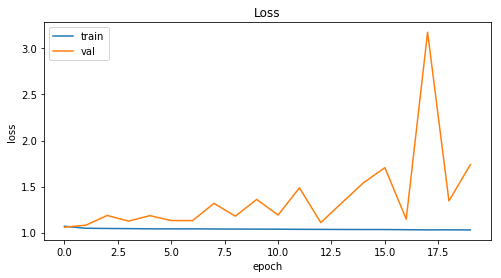

In [23]:
# plot loss during training
plt.figure(figsize=(8,4))
plt.title('Loss')
plt.plot(glove_history.history['loss'], label='train')
plt.plot(glove_history.history['val_loss'], label='test')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

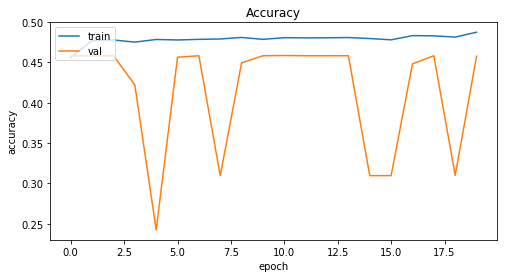

In [24]:
# plot accuracy during training
plt.figure(figsize=(8,4))
plt.title('Accuracy')
plt.plot(glove_history.history['acc'], label='train')
plt.plot(glove_history.history['val_acc'], label='test')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### CNN

In [25]:
cnn_checkpts = ModelCheckpoint(filepath=os.path.join(os.getcwd() + '/saved_models/text/sentiment/cnn.weights.best.hdf5'), 
                               verbose=1, save_best_only=True)
sen_cnn = build_CNN(num_polarities)
sen_cnn.fit(x_train_reshaped, z_train, validation_split=0.4, epochs=5, callbacks=[cnn_checkpts], verbose=1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_7 (Conv1D)            (None, 20000, 16)         48        
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 10000, 16)         0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 10000, 32)         1056      
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 5000, 32)          0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 5000, 64)          4160      
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 2500, 64)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 160000)            0         
__________

5993/5993 [==============================] - ETA: 2:07 - loss: 0.9519 - acc: 0.468 - ETA: 2:10 - loss: 0.9183 - acc: 0.562 - ETA: 2:11 - loss: 0.8883 - acc: 0.625 - ETA: 2:10 - loss: 0.8919 - acc: 0.617 - ETA: 2:10 - loss: 0.8930 - acc: 0.618 - ETA: 2:11 - loss: 0.8927 - acc: 0.614 - ETA: 2:11 - loss: 0.8899 - acc: 0.620 - ETA: 2:12 - loss: 0.8865 - acc: 0.628 - ETA: 2:11 - loss: 0.8904 - acc: 0.618 - ETA: 2:10 - loss: 0.8894 - acc: 0.615 - ETA: 2:10 - loss: 0.8791 - acc: 0.622 - ETA: 2:08 - loss: 0.8781 - acc: 0.606 - ETA: 2:07 - loss: 0.8722 - acc: 0.605 - ETA: 2:06 - loss: 0.8611 - acc: 0.611 - ETA: 2:05 - loss: 0.8659 - acc: 0.604 - ETA: 2:04 - loss: 0.8626 - acc: 0.601 - ETA: 2:03 - loss: 0.8552 - acc: 0.606 - ETA: 2:03 - loss: 0.8450 - acc: 0.618 - ETA: 2:02 - loss: 0.8456 - acc: 0.616 - ETA: 2:01 - loss: 0.8428 - acc: 0.615 - ETA: 2:00 - loss: 0.8419 - acc: 0.617 - ETA: 2:00 - loss: 0.8465 - acc: 0.613 - ETA: 2:00 - loss: 0.8477 - acc: 0.615 - ETA: 1:59 - loss: 0.8439 - acc: 0.6

5993/5993 [==============================] - ETA: 2:27 - loss: 0.3017 - acc: 0.906 - ETA: 2:21 - loss: 0.3332 - acc: 0.906 - ETA: 2:17 - loss: 0.3287 - acc: 0.916 - ETA: 2:19 - loss: 0.3678 - acc: 0.882 - ETA: 2:25 - loss: 0.3684 - acc: 0.893 - ETA: 2:24 - loss: 0.3992 - acc: 0.864 - ETA: 2:25 - loss: 0.3887 - acc: 0.875 - ETA: 2:23 - loss: 0.3885 - acc: 0.875 - ETA: 2:21 - loss: 0.3889 - acc: 0.871 - ETA: 2:21 - loss: 0.3822 - acc: 0.871 - ETA: 2:19 - loss: 0.3742 - acc: 0.872 - ETA: 2:18 - loss: 0.3694 - acc: 0.880 - ETA: 2:17 - loss: 0.3708 - acc: 0.875 - ETA: 2:16 - loss: 0.3683 - acc: 0.877 - ETA: 2:15 - loss: 0.3736 - acc: 0.877 - ETA: 2:14 - loss: 0.3851 - acc: 0.869 - ETA: 2:13 - loss: 0.3842 - acc: 0.869 - ETA: 2:13 - loss: 0.3846 - acc: 0.868 - ETA: 2:13 - loss: 0.3781 - acc: 0.870 - ETA: 2:14 - loss: 0.3821 - acc: 0.870 - ETA: 2:14 - loss: 0.3895 - acc: 0.866 - ETA: 2:13 - loss: 0.3831 - acc: 0.866 - ETA: 2:14 - loss: 0.3714 - acc: 0.872 - ETA: 2:13 - loss: 0.3789 - acc: 0.8

In [26]:
z_pred_cnn = sen_cnn.predict_classes(x_test_reshaped)
Counter(z_pred_cnn)

Counter({1: 1339, 0: 751, 2: 520})

In [62]:
cnn_accuracy = 100*np.sum(z_pred_cnn==z_transf)/len(z_transf)
print('Test accuracy: %.4f%%' % cnn_accuracy)

Test accuracy: 48.5824%
